# 1. Preparación ambiente

In [37]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import math 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import umap
import hdbscan
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

import joblib

In [2]:
random_seed = 333
np.random.seed(random_seed)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_colwidth", None)

sns.set_style("dark")

import plotly.io as pio  # asegúrate de tener este import en la celda de imports
dark_template = pio.templates["plotly_dark"].to_plotly_json()
dark_template["layout"]["paper_bgcolor"] = "rgba(30, 30, 30, 0.5)"
dark_template["layout"]["plot_bgcolor"] = "rgba(30, 30, 30, 0)"
pio.templates["plotly_dark_semi_transparent"] = go.layout.Template(dark_template)
pio.templates.default = "plotly_dark_semi_transparent"

%matplotlib inline

# 2. Carga de Datos

In [5]:
df = pd.read_csv('coyoacan-catastro.csv')

In [6]:
df['clave_rango_nivel'].unique()

array(['02', '05', '01', '10', 'RU', '15', '20', nan, '99'], dtype=object)

# 3. Limpieza y filtrado

Se tomaron en cuenta éstos filtros ya que el dataset completo era muy grande y había alguna rows no relevantes

In [7]:
df = df[(df['superficie_terreno'] >= 15) & 
(df['codigo_postal'] != 0) &
(df['superficie_construccion'] >= 15) &
(df['anio_construccion'] >= 1950) & 
(df['superficie_terreno'] <= 500) & 
(df['superficie_construccion'] <= 500) &
(df['subsidio'] <= 2000) &
(df['valor_suelo'] <= 10000000) &
(df['uso_construccion'] == 'Habitacional')
]

df = df.dropna(subset=['codigo_postal','valor_unitario_suelo', 'clave_rango_nivel', 'instalaciones_especiales'])

df['uso_construccion'].fillna(df['uso_construccion'].mode()[0], inplace=True)
df['clave_rango_nivel'].fillna(df['clave_rango_nivel'].mode()[0], inplace=True)
df['anio_construccion'].fillna(df['anio_construccion'].median(), inplace=True)
df['valor_suelo'].fillna(df['valor_suelo'].median(), inplace=True)

df['instalaciones_especiales'] = df['instalaciones_especiales'].map({'Sí': 1, 'No': 0})

df['clave_rango_nivel'] = df['clave_rango_nivel'].map({'RU': 0, '02': 2, '05':5, '01':1, '99':1, '10':10, '20':20, '15':15})

In [8]:
df.isna().sum()

codigo_postal                 0
superficie_terreno            0
superficie_construccion       0
uso_construccion              0
clave_rango_nivel             0
anio_construccion             0
instalaciones_especiales      0
valor_unitario_suelo          0
valor_suelo                   0
clave_valor_unitario_suelo    0
subsidio                      0
latitud                       0
longitud                      0
colonia                       0
alcaldia                      0
dtype: int64

In [9]:
df.describe()

,codigo_postal,superficie_terreno,superficie_construccion,clave_rango_nivel,anio_construccion,instalaciones_especiales,valor_unitario_suelo,valor_suelo,subsidio,latitud,longitud
count,109473.000000,109473.000000,109473.000000,109473.000000,109473.000000,109473.000000,109473.000000,1.094730e+05,109473.000000,109473.000000,109473.000000
mean,4523.025769,94.072761,142.397243,5.122149,1984.090844,0.309684,4061.923676,3.628674e+05,528.278910,19.326941,-99.138052
std,424.244040,89.443578,91.820906,3.072579,11.659101,0.462365,1396.712105,3.882297e+05,314.015133,0.015791,0.024363
min,13.000000,15.000000,15.000000,0.000000,1950.000000,0.000000,1304.970000,2.153190e+04,0.000000,19.297124,-99.203509
25%,4330.000000,25.000000,75.000000,2.000000,1976.000000,0.000000,3123.510000,1.054175e+05,336.770000,19.312196,-99.156707
50%,4460.000000,50.130000,103.370000,5.000000,1983.000000,0.000000,3764.910000,2.074664e+05,554.060000,19.326648,-99.133204
75%,4720.000000,157.470000,189.000000,5.000000,1991.000000,1.000000,5112.970000,4.865994e+05,696.430000,19.340163,-99.118616
max,16050.000000,500.000000,500.000000,20.000000,2019.000000,1.000000,9185.150000,4.078207e+06,1999.560000,19.358352,-99.100655


# 4. Feature Engineering

Agunas variables construidas a partir de las originales

In [10]:
df['density'] = df['superficie_construccion'] / df['superficie_terreno']
df['modernity_score'] = df['anio_construccion'] - df['anio_construccion'].min()
df['modernity_score'] = df['modernity_score'] / df['modernity_score'].max()

df['valor_relativo'] = df['valor_unitario_suelo'] / df.groupby('colonia')['valor_unitario_suelo'].transform('mean')
df['antiguedad_norm'] = (df['anio_construccion'].max() - df['anio_construccion']) / (df['anio_construccion'].max() - df['anio_construccion'].min())
df['indice_inversion'] = (
    (1 - df['valor_relativo']) * 0.4 +  # bajo valor relativo = más potencial
    (1 - df['density']) * 0.2 +         # baja densidad = posibilidad de ampliar
    df['antiguedad_norm'] * 0.2 +       # más antiguo = posibilidad de renovación
    (df['modernity_score']) * 0.2             # si modernity es un score alto, ponderar según objetivo
)
df['indice_inversion'] = (df['indice_inversion'] - df['indice_inversion'].min()) / (df['indice_inversion'].max() - df['indice_inversion'].min())

# 5. EDA

### Distribuciones de features

In [11]:
feat = ['superficie_terreno',
    'superficie_construccion',
    'density',
    'valor_unitario_suelo',
    'valor_suelo',
    'modernity_score',
    'antiguedad_norm',
    'indice_inversion',
    'clave_rango_nivel',
    'instalaciones_especiales']

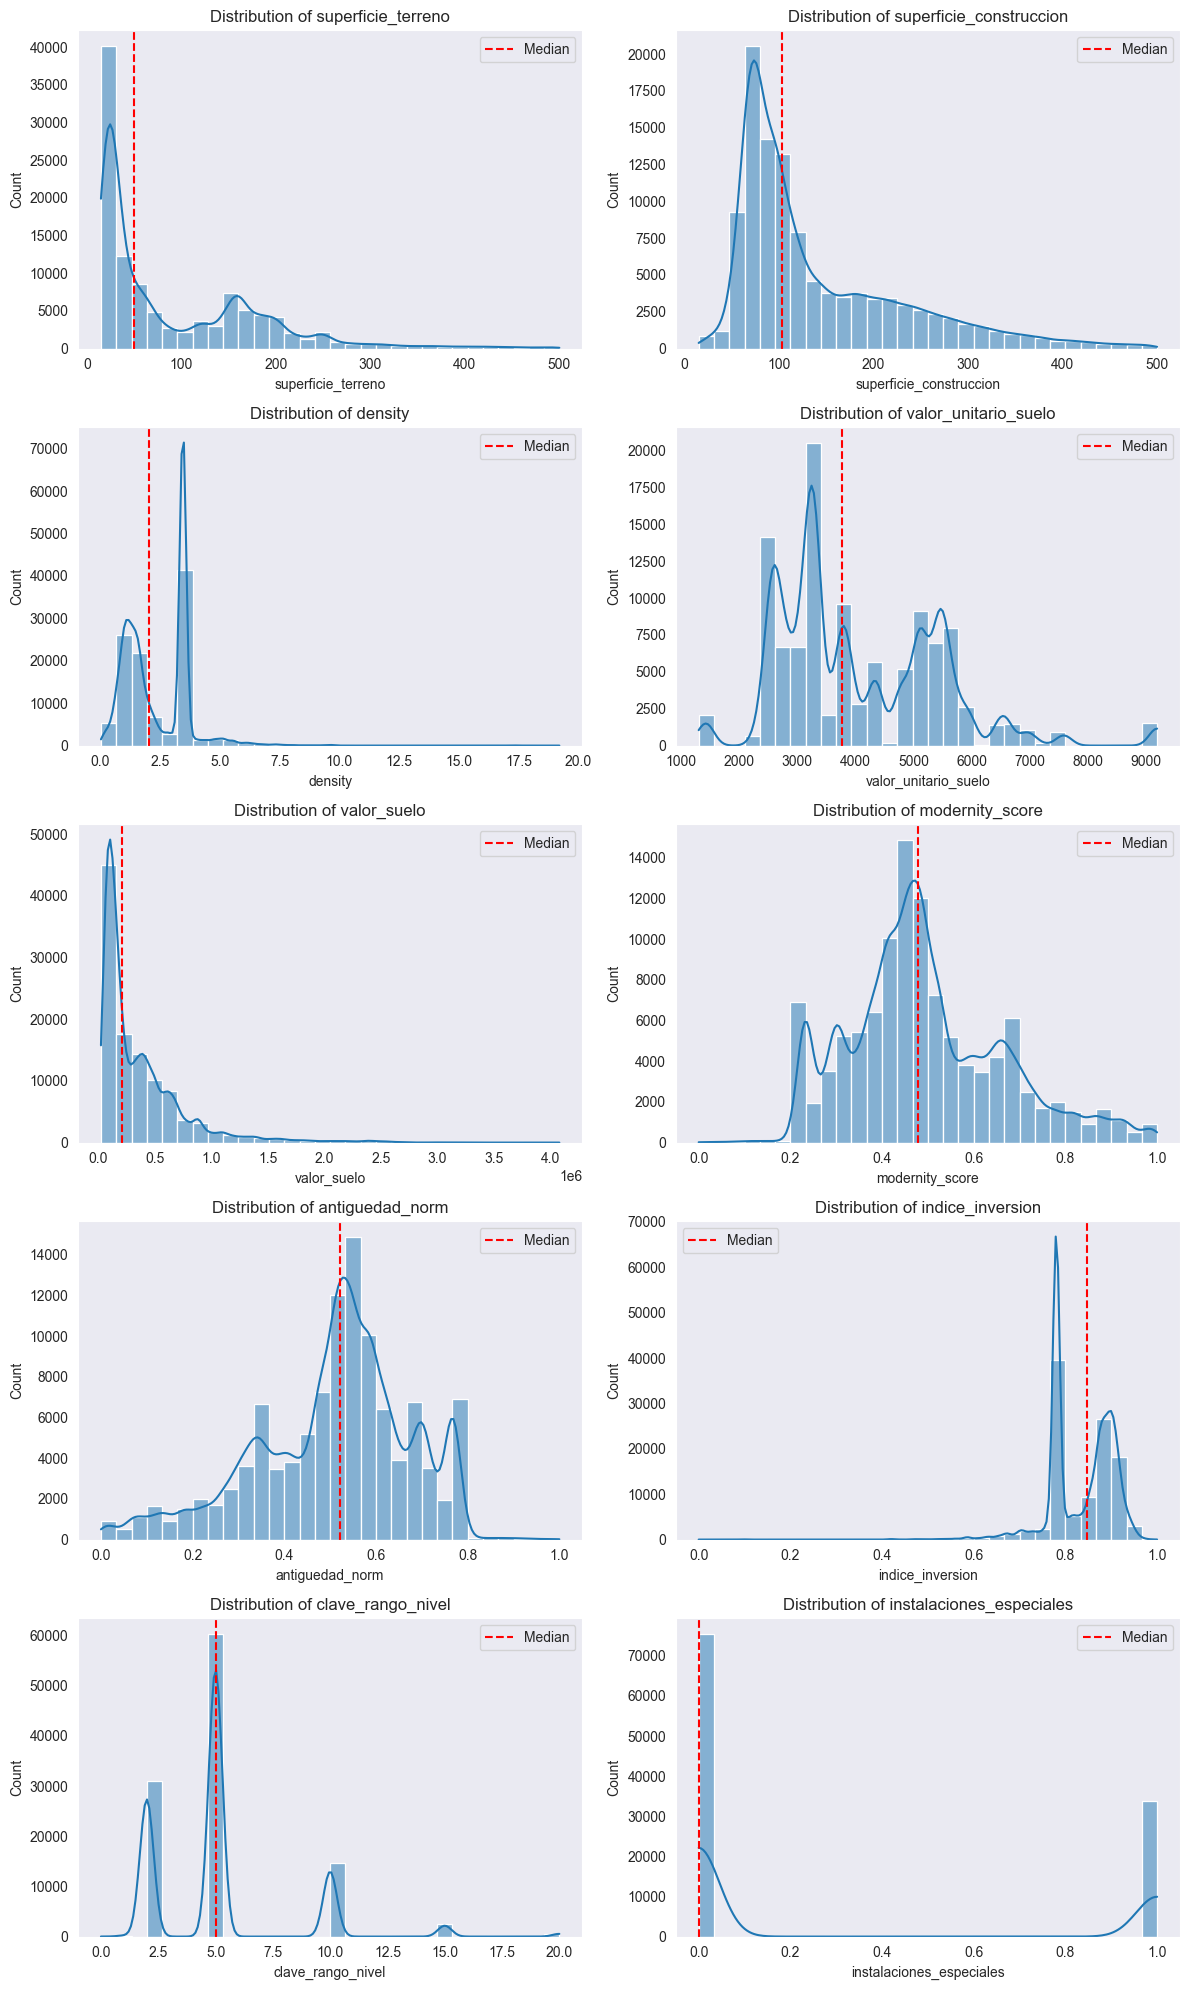

In [12]:
n_cols = 2
n_rows = math.ceil(len(feat) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.ravel()

for i, col in enumerate(feat):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].axvline(df[col].median(), color='r', linestyle='--', label='Median')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("distribuciones.png", dpi=300, bbox_inches='tight')
plt.show()

### Mapa de correlaciones

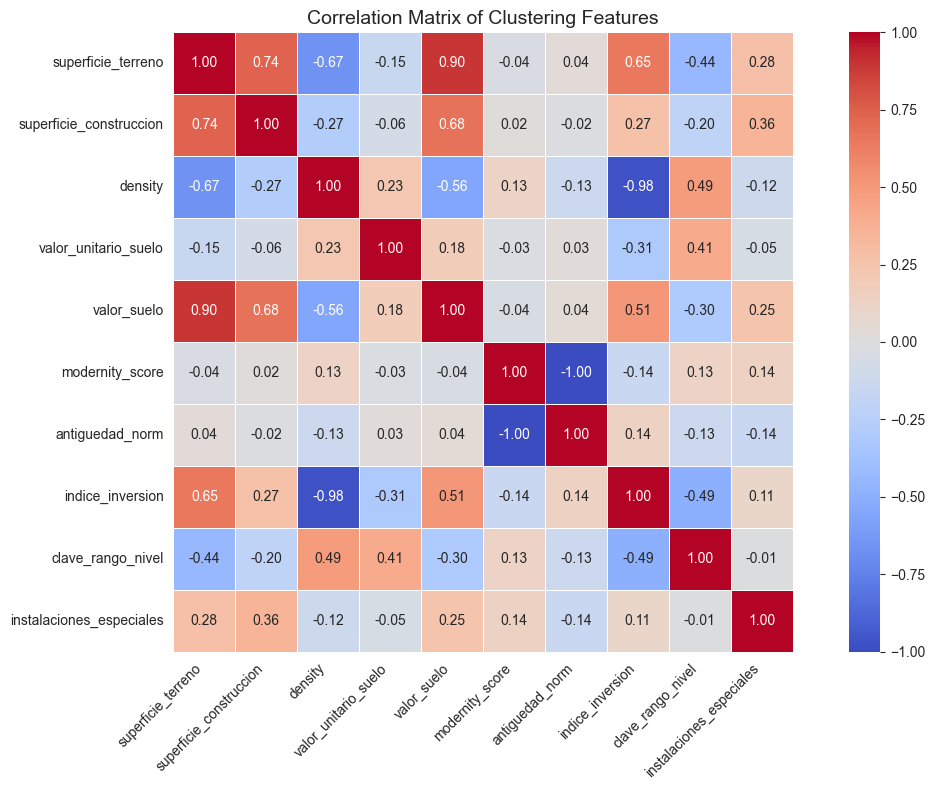

In [13]:
X_corr = df[feat].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    X_corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    fmt='.2f',
    linewidths=0.5,
    square=True
)

plt.title("Correlation Matrix of Clustering Features", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

Debido a correlaciones cercanas a 0 (excepto las creadas a partir de las origniales) usaré t-sne para reducir dimensionalidad

# 6. Preparación de TAD

### 6.1 Log Transform

In [14]:
df_feat = df.copy()

In [15]:
df_feat['log_superficie_terreno'] = np.log1p(df_feat['superficie_terreno'])
df_feat['log_superficie_construccion'] = np.log1p(df_feat['superficie_construccion'])
df_feat['log_valor_unitario_suelo'] = np.log1p(df_feat['valor_unitario_suelo'])
df_feat['log_valor_suelo'] = np.log1p(df_feat['valor_suelo'])

### 6.2 Selección de variables para clustering

In [16]:
cols_for_clust = [
    'log_superficie_terreno',
    'log_superficie_construccion',
    'density',
    'log_valor_unitario_suelo',
    'log_valor_suelo',
    'modernity_score',
    'antiguedad_norm',
    'indice_inversion',
    'clave_rango_nivel',
    'instalaciones_especiales',
    'latitud',
    'longitud'
]

X = df_feat[cols_for_clust].values

### 6.3 Escalado

In [17]:
X = df_feat[cols_for_clust]  

scaler = StandardScaler()
X_scaled_arr = scaler.fit_transform(X)

# Convertimos a DataFrame escalado
X_scaled = pd.DataFrame(X_scaled_arr, columns=cols_for_clust, index=df_feat.index)

### 6.4 Reducir el peso espacial

In [18]:
X_scaled[['latitud', 'longitud']] *= 0.3

In [19]:
df_tad = X_scaled.copy()
df_tad.to_parquet("data/tad_coyoacan.parquet")

# 7. Modelado UMAP + HDBSCAN

### 7.1 UMAP (reducción de dimensionalidad)

In [20]:
umap_reducer = umap.UMAP(
    n_neighbors=30,        
    min_dist=0.1,
    n_components=2,       
    metric='euclidean',
    random_state=42,
    verbose=True
)

X_umap = umap_reducer.fit_transform(X_scaled)

df_feat['umap_x'] = X_umap[:, 0]
df_feat['umap_y'] = X_umap[:, 1]

UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Fri Nov 21 13:34:01 2025 Construct fuzzy simplicial set
Fri Nov 21 13:34:01 2025 Finding Nearest Neighbors
Fri Nov 21 13:34:01 2025 Building RP forest with 22 trees
Fri Nov 21 13:34:09 2025 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Fri Nov 21 13:34:31 2025 Finished Nearest Neighbor Search
Fri Nov 21 13:34:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Nov 21 13:53:03 2025 Finished embedding


### 7.2 HDBSCAN (clustering)

In [21]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=300,      
    min_samples=15,            
    metric='euclidean',
    cluster_selection_method='eom',
    core_dist_n_jobs=-1        
)

labels = clusterer.fit_predict(X_umap)
probs = clusterer.probabilities_

df_feat['cluster_hdbscan'] = labels
df_feat['cluster_prob'] = probs

### 7.3 Resumen del clustering

In [22]:
mask_valid = labels != -1
n_valid = mask_valid.sum()
n_clusters = len(np.unique(labels[mask_valid]))

print(f"N puntos totales: {len(labels)}")
print(f"N puntos asignados a clusters (no ruido): {n_valid}")
print(f"N clusters (sin contar ruido): {n_clusters}")
print("Distribución de tamaños de cluster (incluyendo ruido -1):")
print(pd.Series(labels).value_counts().sort_index())

N puntos totales: 109473
N puntos asignados a clusters (no ruido): 72270
N clusters (sin contar ruido): 75
Distribución de tamaños de cluster (incluyendo ruido -1):
-1     37203
 0       465
 1       659
 2       471
 3       468
       ...  
 70      372
 71     1371
 72     2327
 73      677
 74      465
Name: count, Length: 76, dtype: int64


### 7.4 Métricas de calidad (UMAP space)

In [23]:
if n_valid > 100 and n_clusters > 1:
    max_sample = 20000
    if n_valid > max_sample:
        idx_sample = np.random.choice(np.where(mask_valid)[0], size=max_sample, replace=False)
        X_eval = X_umap[idx_sample]
        y_eval = labels[idx_sample]
    else:
        X_eval = X_umap[mask_valid]
        y_eval = labels[mask_valid]

    sil = silhouette_score(X_eval, y_eval)
    db = davies_bouldin_score(X_eval, y_eval)

    print(f"Silhouette score (UMAP space, sin ruido): {sil:.4f}")
    print(f"Davies-Bouldin (UMAP space, sin ruido): {db:.4f}")
else:
    print("No hay suficientes puntos/clusters válidos para calcular métricas fiables.")

Silhouette score (UMAP space, sin ruido): 0.4034
Davies-Bouldin (UMAP space, sin ruido): 0.7571


# 8. Perfilamiento de clusters

In [26]:
# Excluimos ruido
df_clusters = df_feat[df_feat['cluster_hdbscan'] != -1].copy()

### 8.1 Perfil numérico por cluster

In [27]:
cluster_profile = (
    df_clusters
    .groupby('cluster_hdbscan')
    .agg(
        n_predios=('cluster_hdbscan', 'size'),
        superficie_terreno_med=('superficie_terreno', 'median'),
        superficie_construccion_med=('superficie_construccion', 'median'),
        density_med=('density', 'median'),
        valor_unitario_suelo_med=('valor_unitario_suelo', 'median'),
        valor_suelo_med=('valor_suelo', 'median'),
        modernity_med=('modernity_score', 'median'),
        antiguedad_norm_med=('antiguedad_norm', 'median'),
        indice_inversion_med=('indice_inversion', 'median'),
        instalaciones_especiales_pct=('instalaciones_especiales', 'mean'),
        lat_med=('latitud', 'median'),
        lon_med=('longitud', 'median')
    )
    .sort_values('indice_inversion_med', ascending=False)
)

### 8.2 Top colonias por cluster

In [28]:
top_colonias = (
    df_clusters
    .groupby(['cluster_hdbscan', 'colonia'])
    .size()
    .groupby(level=0)
    .apply(lambda s: (s / s.sum()).sort_values(ascending=False).head(5))
)

# 9. Mapeo y distribución de clusters

In [29]:
# Máscaras
mask_noise = df_feat["cluster_hdbscan"] == -1
mask_clust = ~mask_noise

### 9.1 UMAP: clusters en 2D

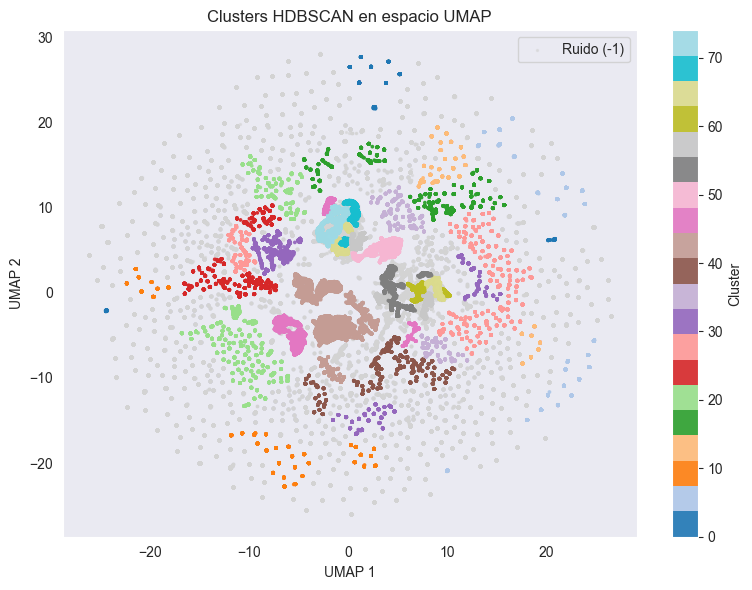

In [30]:
plt.figure(figsize=(8, 6))

plt.scatter(
    df_feat.loc[mask_noise, 'umap_x'],
    df_feat.loc[mask_noise, 'umap_y'],
    s=2, c='lightgrey', label='Ruido (-1)', alpha=0.5
)

scatter = plt.scatter(
    df_feat.loc[mask_clust, 'umap_x'],
    df_feat.loc[mask_clust, 'umap_y'],
    s=3,
    c=df_feat.loc[mask_clust, 'cluster_hdbscan'],
    cmap='tab20',
    alpha=0.9
)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Clusters HDBSCAN en espacio UMAP')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.tight_layout()
plt.show()

### 9.2 Mapa espacial lat/lon

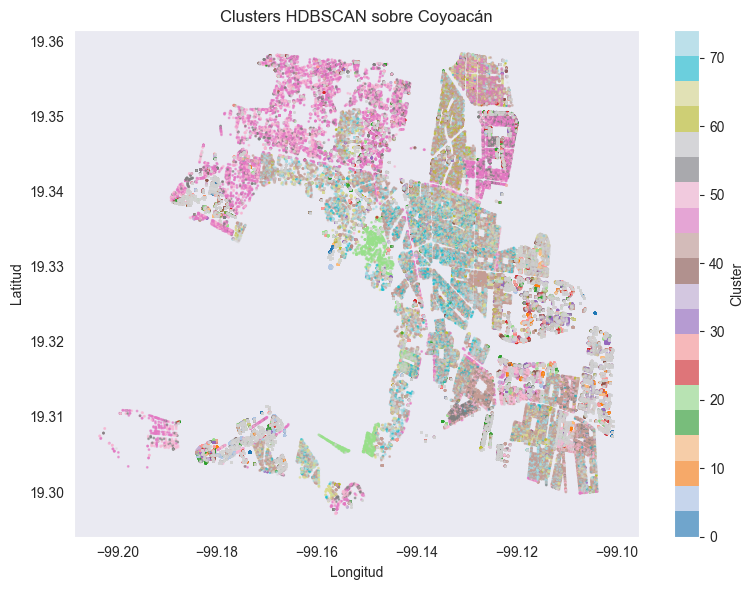

In [31]:
plt.figure(figsize=(8, 6))

scatter_map = plt.scatter(
    df_feat.loc[mask_clust, 'longitud'],
    df_feat.loc[mask_clust, 'latitud'],
    s=1,
    c=df_feat.loc[mask_clust, 'cluster_hdbscan'],
    cmap='tab20',
    alpha=0.6
)

plt.scatter(
    df_feat.loc[mask_noise, 'longitud'],
    df_feat.loc[mask_noise, 'latitud'],
    s=1, c='lightgrey', alpha=0.2
)

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters HDBSCAN sobre Coyoacán')
plt.colorbar(scatter_map, label='Cluster')
plt.tight_layout()
plt.show()

### 9.3 Distribución de clusters

In [32]:
dist_clusters = (
    df_feat['cluster_hdbscan']
    .value_counts(normalize=True)
    .sort_index()
)

sizes_clusters = (
    df_feat['cluster_hdbscan']
    .value_counts()
    .sort_index()
)
print("\nProporción por cluster (incluyendo ruido -1):")
print(dist_clusters)

print("\nTamaño absoluto por cluster (incluyendo ruido -1):")
print(sizes_clusters)


Proporción por cluster (incluyendo ruido -1):
cluster_hdbscan
-1     0.339837
 0     0.004248
 1     0.006020
 2     0.004302
 3     0.004275
         ...   
 70    0.003398
 71    0.012524
 72    0.021256
 73    0.006184
 74    0.004248
Name: proportion, Length: 76, dtype: float64

Tamaño absoluto por cluster (incluyendo ruido -1):
cluster_hdbscan
-1     37203
 0       465
 1       659
 2       471
 3       468
       ...  
 70      372
 71     1371
 72     2327
 73      677
 74      465
Name: count, Length: 76, dtype: int64


# 10. Evaluación

In [33]:
labels = df_feat['cluster_hdbscan'].values

mask_valid = labels != -1
X_valid = X_umap[mask_valid]
y_valid = labels[mask_valid]

max_sample = 20000
if X_valid.shape[0] > max_sample:
    idx = np.random.choice(X_valid.shape[0], size=max_sample, replace=False)
    X_eval = X_valid[idx]
    y_eval = y_valid[idx]
else:
    X_eval = X_valid
    y_eval = y_valid

if len(np.unique(y_eval)) > 1:
    sil = silhouette_score(X_eval, y_eval)
    db = davies_bouldin_score(X_eval, y_eval)
    print(f"Silhouette (UMAP, sin ruido): {sil:.4f}")
    print(f"Davies-Bouldin (UMAP, sin ruido): {db:.4f}")
else:
    print("Sólo hay un cluster válido, no se pueden calcular métricas.")

Silhouette (UMAP, sin ruido): 0.4026
Davies-Bouldin (UMAP, sin ruido): 0.7560


# 11. Reagrupamiento por similitud de clusters (macro-clusters humanos)

### 11.1 Perfil resumido por cluster HDBSCAN

In [34]:
cluster_profile = (
    df_feat[df_feat['cluster_hdbscan'] != -1]
    .groupby('cluster_hdbscan')
    .agg(
        n_predios=('cluster_hdbscan', 'size'),
        valor_unitario_suelo_med=('valor_unitario_suelo', 'median'),
        density_med=('density', 'median'),
        indice_inversion_med=('indice_inversion', 'median'),
        antiguedad_norm_med=('antiguedad_norm', 'median')
    )
    .sort_values('indice_inversion_med', ascending=False)
)

cluster_profile.head()

,n_predios,valor_unitario_suelo_med,density_med,indice_inversion_med,antiguedad_norm_med
cluster_hdbscan,,,,,
67,549,2822.24,0.196629,0.947142,0.362319
69,618,2593.33,0.703774,0.924943,0.637681
65,402,2593.33,0.681710,0.921726,0.579710
66,336,2822.24,0.843369,0.917181,0.318841
21,780,1435.46,0.896755,0.913076,0.362319


### 11.2 Resumen numérico para reclustering

In [35]:
cluster_summary = (
    df_feat[df_feat["cluster_hdbscan"] != -1]
    .groupby("cluster_hdbscan")
    .agg({
        "valor_unitario_suelo": "median",
        "density": "median",
        "indice_inversion": "median",
        "antiguedad_norm": "median",
        "modernity_score": "median",
        "superficie_terreno": "median",
        "superficie_construccion": "median",
    })
)

cluster_summary.head()

,valor_unitario_suelo,density,indice_inversion,antiguedad_norm,modernity_score,superficie_terreno,superficie_construccion
cluster_hdbscan,,,,,,,
0,5112.97,3.476190,0.779125,0.478261,0.521739,21.00,73.00
1,3946.77,1.482517,0.877933,0.347826,0.652174,51.48,76.32
2,2666.28,1.062500,0.898750,0.333333,0.666667,48.00,51.00
3,3764.91,1.485961,0.877763,0.710145,0.289855,50.00,65.20
4,5112.97,3.470588,0.779403,0.550725,0.449275,23.00,91.00


### 11.3 Escalado + KMeans sobre clusters (macro-clusters)

In [38]:
scaler2 = StandardScaler()
summary_scaled = scaler2.fit_transform(cluster_summary.values)

k = 10  
kmeans = KMeans(n_clusters=k, random_state=42)
macro_labels = kmeans.fit_predict(summary_scaled)

cluster_summary["macro_cluster"] = macro_labels

macro_profile = (
    cluster_summary
    .groupby("macro_cluster")
    .mean()
    .round(3)
)

macro_profile

,valor_unitario_suelo,density,indice_inversion,antiguedad_norm,modernity_score,superficie_terreno,superficie_construccion
macro_cluster,,,,,,,
0,3737.333,3.416,0.782,0.507,0.493,26.210,89.012
1,3099.814,1.007,0.904,0.597,0.403,99.400,89.440
2,3438.057,1.563,0.876,0.459,0.541,169.107,272.455
3,3053.771,1.176,0.895,0.359,0.641,93.766,84.683
4,5341.874,3.448,0.778,0.434,0.566,25.125,89.254
5,3026.170,1.206,0.898,0.710,0.290,163.800,201.800
6,5563.970,3.580,0.755,0.130,0.870,37.000,145.400
7,5431.495,1.263,0.888,0.536,0.464,196.000,243.514
8,4825.594,3.412,0.783,0.588,0.412,28.648,94.192


### 11.4 Mapear cada predio a macro-cluster humano

In [39]:
map_original_to_macro = cluster_summary["macro_cluster"].to_dict()
df_feat["cluster_humano"] = df_feat["cluster_hdbscan"].map(map_original_to_macro)

nombres_macro = {
    0: "Pequeño en zona de pusvalía media-alta",
    1: "Antiguo con espacio para construcción",
    2: "Conjunto habitacional grande",
    3: "Moderno pequeña en zona media",
    4: "Pequeño en zona de alta plusvalía",
    5: "Grande y antiguo",
    6: "Moderno en zona de alta plusvalía",
    7: "Grande de alta plusvalía",
    8: "Pequeño antiguo en zona de alta plusvalía",
    9: "Mediano en zona de pusvalía media",
}

In [40]:
df_feat["categoria_cluster"] = df_feat["cluster_humano"].map(nombres_macro)

# 12. Clean up de dataset final

In [41]:
df_feat.columns

Index(['codigo_postal', 'superficie_terreno', 'superficie_construccion',
       'uso_construccion', 'clave_rango_nivel', 'anio_construccion',
       'instalaciones_especiales', 'valor_unitario_suelo', 'valor_suelo',
       'clave_valor_unitario_suelo', 'subsidio', 'latitud', 'longitud',
       'colonia', 'alcaldia', 'density', 'modernity_score', 'valor_relativo',
       'antiguedad_norm', 'indice_inversion', 'log_superficie_terreno',
       'log_superficie_construccion', 'log_valor_unitario_suelo',
       'log_valor_suelo', 'umap_x', 'umap_y', 'cluster_hdbscan',
       'cluster_prob', 'cluster_humano', 'categoria_cluster'],
      dtype='object')

In [42]:
df_feat["cal_inv"] = (df_feat["indice_inversion"] * 10).round(1)

In [43]:
consejo_categoria = {
    0: "Comprar si el precio es bueno y destinar a renta.",
    1: "Renovar y revender; alto potencial de revalorización.",
    2: "Desarrollar proyecto residencial o renta a escala.",
    3: "Buena opción para renta estable o primera vivienda.",
    4: "Ideal para comprar y rentar a corto plazo.",
    5: "Evaluar remodelación profunda; ideal para proyecto grande.",
    6: "Rentar de inmediato; casi no requiere inversión.",
    7: "Actualizar acabados y capitalizar la ubicación.",
    8: "Renovar departamentos y mejorar rentas actuales.",
    9: "Hacer mejoras ligeras y mantener a mediano plazo.",
}

df_feat["consejo_inversion"] = df_feat["cluster_humano"].map(
    consejo_categoria
)

In [44]:
df_feat.head()

,codigo_postal,superficie_terreno,superficie_construccion,uso_construccion,clave_rango_nivel,anio_construccion,instalaciones_especiales,valor_unitario_suelo,valor_suelo,clave_valor_unitario_suelo,subsidio,latitud,longitud,colonia,alcaldia,density,modernity_score,valor_relativo,antiguedad_norm,indice_inversion,log_superficie_terreno,log_superficie_construccion,log_valor_unitario_suelo,log_valor_suelo,umap_x,umap_y,cluster_hdbscan,cluster_prob,cluster_humano,categoria_cluster,cal_inv,consejo_inversion
5,4100.0,262.17,336.85,Habitacional,2,1972.0,1,5389.03,1412842.00,A040147,0.00,19.357500,-99.170232,DEL CARMEN,COYOACAN,1.284853,0.318841,0.999907,0.681159,0.887739,5.572800,5.822602,8.592306,14.161115,-5.405894,-6.577376,47,1.000000,7.0,Grande de alta plusvalía,8.9,Actualizar acabados y capitalizar la ubicación.
6,4110.0,394.00,366.00,Habitacional,5,1967.0,1,5389.03,2123277.82,A040147,0.00,19.357363,-99.170200,DEL CARMEN,COYOACAN,0.928934,0.246377,0.999907,0.753623,0.905379,5.978886,5.905362,8.592306,14.568472,-7.410656,-4.246441,46,1.000000,7.0,Grande de alta plusvalía,9.1,Actualizar acabados y capitalizar la ubicación.
7,4100.0,390.00,363.00,Habitacional,5,1967.0,1,5389.03,2101721.70,A040147,0.00,19.357416,-99.170392,DEL CARMEN,COYOACAN,0.930769,0.246377,0.999907,0.753623,0.905288,5.968708,5.897154,8.592306,14.558268,-7.409969,-4.248822,46,1.000000,7.0,Grande de alta plusvalía,9.1,Actualizar acabados y capitalizar la ubicación.
8,4100.0,208.00,225.00,Habitacional,5,2000.0,0,5389.03,1120918.24,A040147,561.83,19.357551,-99.170589,DEL CARMEN,COYOACAN,1.081731,0.724638,0.999907,0.275362,0.897806,5.342334,5.420535,8.592306,13.929660,3.680723,1.589591,55,0.830667,7.0,Grande de alta plusvalía,9.0,Actualizar acabados y capitalizar la ubicación.
9,4100.0,208.00,225.00,Habitacional,5,2000.0,0,5389.03,1120918.24,A040147,561.83,19.357551,-99.170589,DEL CARMEN,COYOACAN,1.081731,0.724638,0.999907,0.275362,0.897806,5.342334,5.420535,8.592306,13.929660,3.681794,1.562897,55,0.830667,7.0,Grande de alta plusvalía,9.0,Actualizar acabados y capitalizar la ubicación.


# 13. Archivos requeridos para despliegue

In [45]:
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Guardar dataset final (para Streamlit)
df_feat.to_parquet("data/coyoacan_clusters.parquet", index=False)

# Guardar modelos requeridos
joblib.dump(scaler, "models/scaler.pkl")                 
joblib.dump(umap_reducer, "models/umap_reducer.pkl")    
joblib.dump(clusterer, "models/hdbscan.pkl")             
joblib.dump(kmeans, "models/kmeans_macro.pkl")           

# Guardar archivos de metadatos / resúmenes
joblib.dump(cluster_summary, "models/cluster_summary.pkl")            
joblib.dump(macro_profile, "models/macro_profile.pkl")                
joblib.dump(map_original_to_macro, "models/map_original_to_macro.pkl")
joblib.dump(nombres_macro, "models/nombres_macro.pkl")            

Fri Nov 21 14:19:28 2025 Worst tree score: 0.95016123
Fri Nov 21 14:19:28 2025 Mean tree score: 0.95424318
Fri Nov 21 14:19:28 2025 Best tree score: 0.96978250
Fri Nov 21 14:19:33 2025 Forward diversification reduced edges from 3284190 to 1178838
Fri Nov 21 14:19:36 2025 Reverse diversification reduced edges from 1178838 to 1178824
Fri Nov 21 14:19:38 2025 Degree pruning reduced edges from 1245916 to 1245906
Fri Nov 21 14:19:38 2025 Resorting data and graph based on tree order
Fri Nov 21 14:19:38 2025 Building and compiling search function


['models/nombres_macro.pkl']